In [1]:
%load_ext autoreload
%autoreload 2

In [101]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import optuna
from prettytable import PrettyTable
import pickle
from functools import partial
import numpy as np
from tqdm import tqdm
from glob import glob
from collections.abc import Iterable
from collections import defaultdict

from utils import get_dfs, plot_metric, draw_trajectories

In [3]:
def plot_training_evolution(name, wind_dirs=[45, 90, 135, 180, 225, 270, 315], model_folder=None, eval=True, show_reward=False):
  def extract_step(filename):
    res = re.search(rf'{name}-(\d+)', filename)
    return int(res.group(1))

  def extract_env(filename):
    res = re.search(r'-(\d+)/0/', filename)
    return int(res.group(1))

  if model_folder is None:
    model_folder = name

  files = glob(f'../runs/{name}-*')
  files = sorted(files, key=extract_step)
  if len(files) == 0:
    files = glob(f'../runs/{name}')

  print(f'Found {len(files)} files')

  folder = 'eval' if eval else 'train'

  by_wind = defaultdict(list)
  by_step = defaultdict(list)
  steps = set()
  for i, file in enumerate(files):
    dfs = get_dfs(f'{file}/{folder}-*/0/')
    for key, df in dfs.items():
      wind_idx = extract_env(key)
      wind_dir = wind_dirs[wind_idx]
      step = extract_step(key)
      steps.add(step)
      score = df[f'obs/cum_obs/vmc/0'].iloc[-1]*.1
      if show_reward:
        cum_reward = df[f'reward'].sum()
      else:
        cum_reward = 0
      by_wind[wind_dir].append((score, cum_reward))
      by_step[step].append((score, cum_reward))

  args = pickle.load(open(f'../runs/{model_folder}/model_args.pkl', 'rb'))
  print('Hparams:')
  pt = PrettyTable()
  pt.field_names = ['Name', 'Value']
  for k, v in args.__dict__.items():
    if k in ['name', 'env_name', 'seed', 'reward_kwargs', 'policy_kwargs']:
      continue
    pt.add_row([k, v])
  print(pt)
  print()

  print('Mean scores by step:')
  pt = PrettyTable()
  pt.field_names = ['Step', 'Mean score', 'Mean cum. reward']
  for step, data in by_step.items():
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    pt.add_row([f'{round(step/1e3):d}K', np.mean(scores), np.mean(cum_reward)])
  print(pt)
  print()

  steps = list(sorted(steps))

  if show_reward:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
  else:
    fig, axs = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    axs = [axs]
  for wind_dir in wind_dirs:
    data = by_wind[wind_dir]
    data = np.array(data)
    scores = data[:, 0]
    cum_reward = data[:, 1]
    axs[0].plot(steps, scores, label=f'{wind_dir}°')
    if show_reward:
      axs[1].plot(steps, cum_reward)
  axs[0].set_xlabel('Training step')
  if show_reward:
    axs[1].set_xlabel('Training step')
  axs[0].set_ylabel('Cum. dist.')
  axs[0].set_ylabel('Cum. reward')
  fig.suptitle(name)
  # right legend
  fig.legend(bbox_to_anchor=(1.05, .5), loc='center left')

<Axes: xlabel='Timesteps', ylabel='Cum. dist.'>

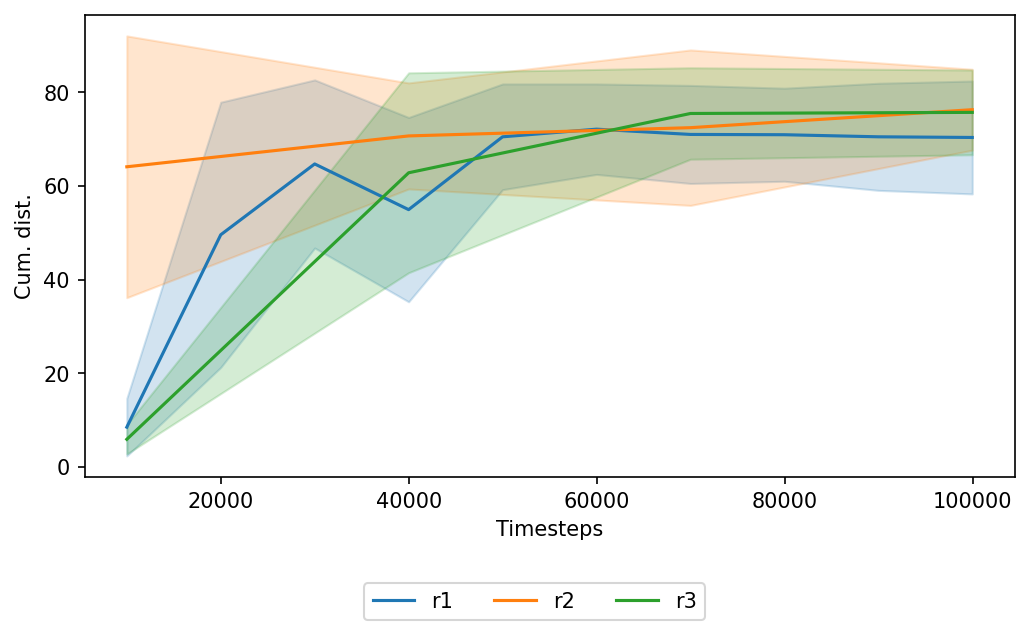

In [41]:
def metric(filename, df):
  step_idx = int(re.search(r'(\d+)(-steps|/)', filename).group(1))
  return step_idx, df['obs/cum_obs/vmc/0'].iloc[-1]*.1

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
plot_metric(
  [
    ('08-31-maxmin-A1-5-*/eval-*/0/', 'r1'),
    # ('08-31-maxminpenalize-A1-5-*/eval-*/0/', 'r2'),
    # ('08-31-maxminpenalize-A2-5-*/eval-*/0/', 'r3'),
    ('08-31-maxminminrudder-A1-5-*/eval-*/0/', 'r2'),
    ('08-31-maxminminrudder-A2-5-*/eval-*/0/', 'r3'),
  ],
  ax=ax,
  metric=metric,
  y_label='Cum. dist.')

<Axes: xlabel='Timesteps', ylabel='XTE'>

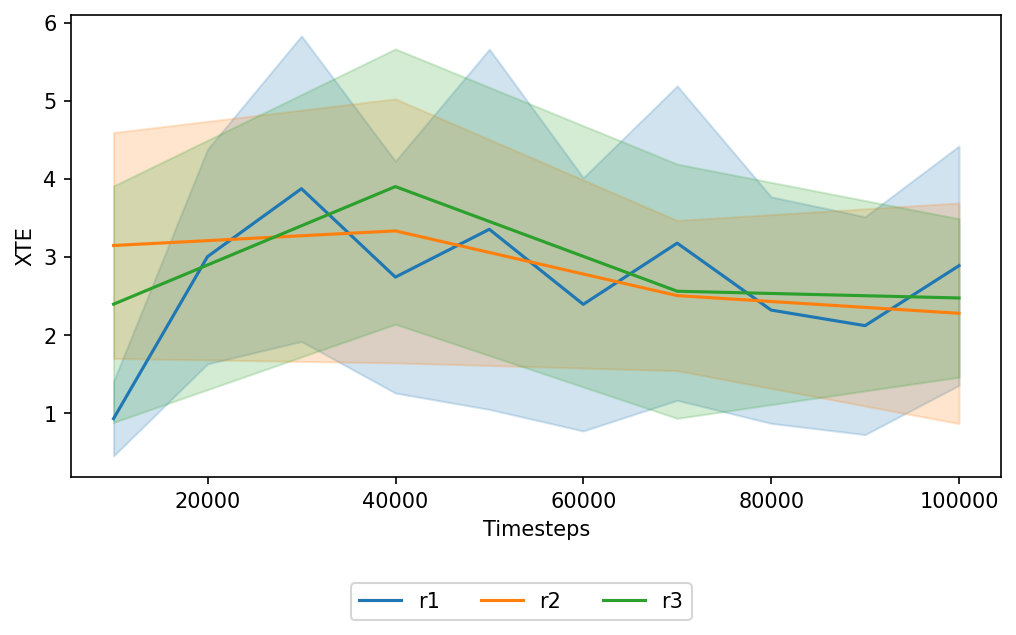

In [103]:
def metric(filename, df):
  step_idx = int(re.search(r'(\d+)(-steps|/)', filename).group(1))
  return step_idx, np.abs(df['obs/xte/0']).mean()

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
plot_metric(
  [
    ('08-31-maxmin-A1-5-*/eval-*/0/', 'r1'),
    ('08-31-maxminminrudder-A1-5-*/eval-*/0/', 'r2'),
    ('08-31-maxminminrudder-A2-5-*/eval-*/0/', 'r3'),
  ],
  ax=ax,
  metric=metric,
  y_label='XTE')

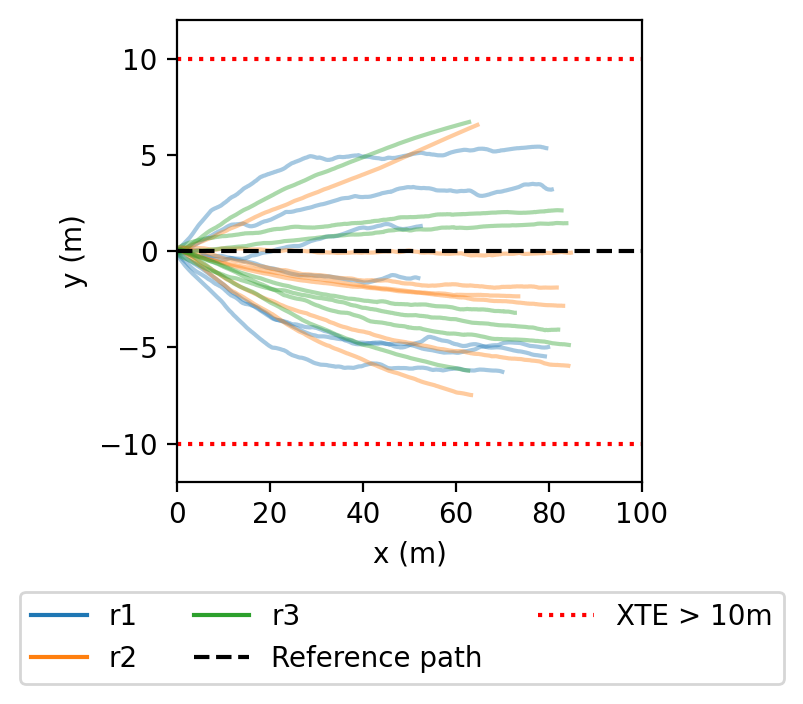

In [92]:
names = [
  '08-31-maxmin-A1-5-99960/eval*/0',
  '08-31-maxminminrudder-A1-5-99960/eval*/0',
  '08-31-maxminminrudder-A2-5-99960/eval*/0',
]
labels = ['r1', 'r2', 'r3']

xte_delta = 10

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

ax.plot([0, 200], [-xte_delta, -xte_delta], 'r:')
for i, (name, label) in enumerate(zip(names, labels)):
  color = f'C{i}'
  files = glob(f'../runs/{name}/*.csv', recursive=True)
  for file in files:
    try:
      df = pd.read_csv(file)
      ax.plot(df["obs/p_boat/0"], df["obs/p_boat/1"],
            alpha=0.4, color=color, linewidth=1.5)
    except:
      continue

for i, label in enumerate(labels):
  ax.plot([], [], color=f'C{i}', label=label)

ax.plot([0, 200], [0, 0], 'k--', label='Reference path')
ax.plot([0, 200], [xte_delta, xte_delta], 'r:', label='XTE > 10m')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_xlim(0, 100)
ax.set_ylim(-xte_delta * 1.2, xte_delta * 1.2)
fig.legend(loc='upper center',
            bbox_to_anchor=(0.5, -.05),
            ncol=len(labels))


sb3:   3%|▎         | 3/93 [00:00<00:05, 17.93it/s]

No data for ../runs/08-31-maxminminrudder-A3


sb3:   9%|▊         | 8/93 [00:00<00:05, 15.55it/s]

No data for ../runs/08-31-maxminminrudder-A2


sb3:  14%|█▍        | 13/93 [00:00<00:04, 16.14it/s]

No data for ../runs/08-31-debug-E0
No data for ../runs/08-31-maxminpenalize-A3


sb3:  24%|██▎       | 22/93 [00:01<00:04, 15.85it/s]

No data for ../runs/08-31-maxmin-A1
No data for ../runs/08-31-maxminpenalize-A2


sb3:  31%|███       | 29/93 [00:01<00:04, 15.54it/s]

No data for ../runs/08-31-max2xpenalize-1


sb3:  56%|█████▌    | 52/93 [00:03<00:03, 13.13it/s]

No data for ../runs/08-31-debug-2-E0


sb3:  63%|██████▎   | 59/93 [00:04<00:02, 13.11it/s]

No data for ../runs/08-31-maxminminrudder-A1


sb3:  70%|██████▉   | 65/93 [00:04<00:02, 13.37it/s]

No data for ../runs/08-31-maxmin-A3


sb3:  75%|███████▌  | 70/93 [00:04<00:01, 16.72it/s]

No data for ../runs/08-31-maxmin-A2
No data for ../runs/08-31-maxminpenalize-A1
No data for ../runs/08-31-max2xpenalize-2


sb3:  86%|████████▌ | 80/93 [00:05<00:00, 16.16it/s]

No data for ../runs/08-31-max2xpenalize-3


sb3:  91%|█████████▏| 85/93 [00:05<00:00, 17.68it/s]

No data for ../runs/08-31-max2xpenalize-delta-4


sb3:  97%|█████████▋| 90/93 [00:06<00:00, 15.89it/s]

No data for ../runs/08-31-max2xpenalize-delta-5


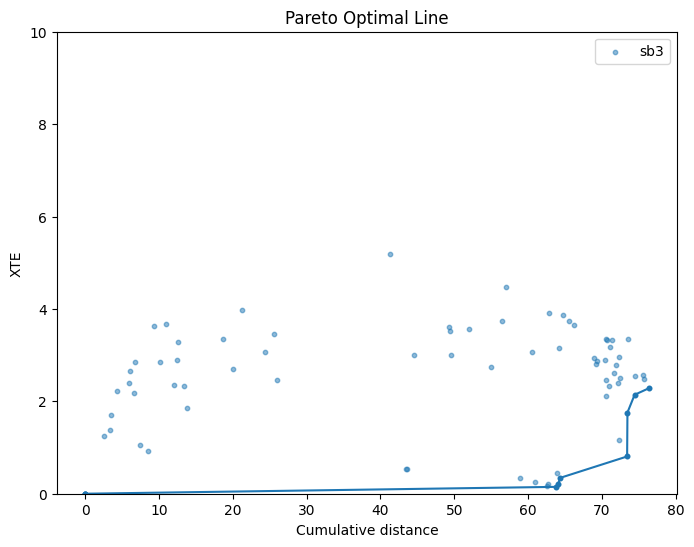

In [120]:
names = [
  '08-31-*',
]
labels = ['sb3']

import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd

def plot_pareto_optimal_line(data, label=None, color=None):
  # Sort the data based on the first dimension (maximizing)
  sorted_data = data[np.argsort(data[:, 0])[::-1]]

  pareto_front = [sorted_data[0]]

  for point in sorted_data[1:]:
    if point[1] <= pareto_front[-1][1]:
      pareto_front.append(point)

  pareto_front = np.array(pareto_front)
  plt.scatter(data[:, 0], data[:, 1], label=label, s=10, alpha=0.5, color=color)
  plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=10, color=color)
  plt.plot(pareto_front[:, 0], pareto_front[:, 1], color=color)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

plt.figure(figsize=(8, 6))
for i, (name, label) in enumerate(zip(names, labels)):
  files = glob(f'../runs/{name}', recursive=True)
  data = []
  for file in tqdm(files, desc=label, leave=False):
    mean_xte = 0
    mean_dist = 0
    envs = glob(f'{file}/eval-*/0/*.csv')
    if len(envs) == 0:
      continue
    for env in envs:
      try:
        df = pd.read_csv(env)
        mean_xte += np.abs(df["obs/xte/0"]).mean()
        mean_dist += df["obs/cum_obs/vmc/0"].iloc[-1]*.1
      except:
        continue
    mean_xte /= len(envs)
    mean_dist /= len(envs)
    data.append([mean_dist, mean_xte])
  data = np.array(data)
  pickle.dump(data, open(f'../{name}_pareto.pkl', 'wb'))
  plot_pareto_optimal_line(data, label=label, color=colors[i])

plt.ylim(0, 10)
plt.xlabel('Cumulative distance')
plt.ylabel('XTE')
plt.title('Pareto Optimal Line')
plt.legend()
plt.show()



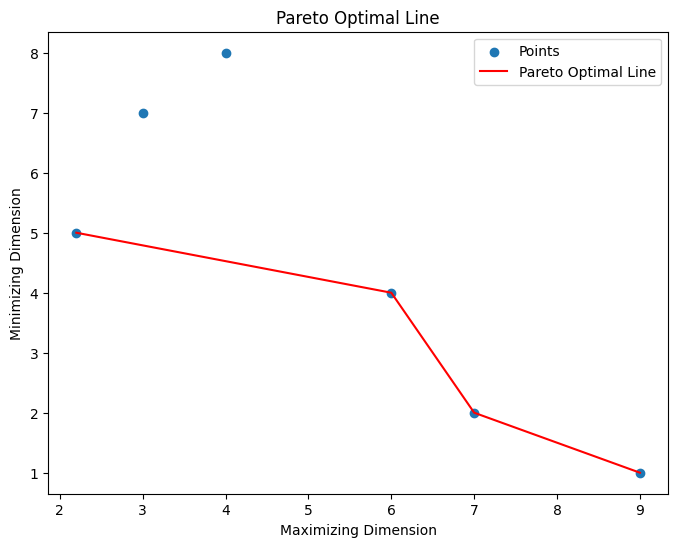

In [93]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pareto_optimal_line(data):
    # Sort the data based on the first dimension (maximizing)
    sorted_data = data[np.argsort(data[:, 0])]

    pareto_front = [sorted_data[0]]

    for point in sorted_data[1:]:
        if point[1] <= pareto_front[-1][1]:
            pareto_front.append(point)

    pareto_front = np.array(pareto_front)

    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], label='Points')
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], color='red', label='Pareto Optimal Line')
    plt.xlabel('Maximizing Dimension')
    plt.ylabel('Minimizing Dimension')
    plt.title('Pareto Optimal Line')
    plt.legend()
    plt.show()

# Example data (replace this with your own data)
data = np.array([[4, 8], [7, 2], [2.2, 5], [9, 1], [6, 4], [3, 7]])
plot_pareto_optimal_line(data)